In [ ]:
LR

图像样本数: 3344, 特征维度: 1024
类别: [np.str_('Eh-1-1'), np.str_('Eh-1-2'), np.str_('Eh-1-3'), np.str_('Eh-1-4'), np.str_('N-1-1'), np.str_('N-1-2'), np.str_('N-1-3'), np.str_('N-1-4'), np.str_('N-1-5')]
训练样本数: 3009, 测试样本数: 335
Epoch 5/30, Loss: 1.9013
Epoch 10/30, Loss: 1.8415
Epoch 15/30, Loss: 1.8008
Epoch 20/30, Loss: 1.7637
Epoch 25/30, Loss: 1.7325
Epoch 30/30, Loss: 1.7060
测试集准确率: 0.3522
分类报告:
              precision    recall  f1-score   support

      Eh-1-1       0.47      0.19      0.27        37
      Eh-1-2       0.35      0.31      0.33        61
      Eh-1-3       0.29      0.38      0.33        42
      Eh-1-4       0.30      0.27      0.28        49
       N-1-1       0.37      0.66      0.47        87
       N-1-2       0.67      0.27      0.39        22
       N-1-3       0.00      0.00      0.00        13
       N-1-4       0.00      0.00      0.00         6
       N-1-5       0.00      0.00      0.00        18

    accuracy                           0.35       335
   macro 

C:\Users\17531\.conda\envs\torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\17531\.conda\envs\torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\17531\.conda\envs\torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\U

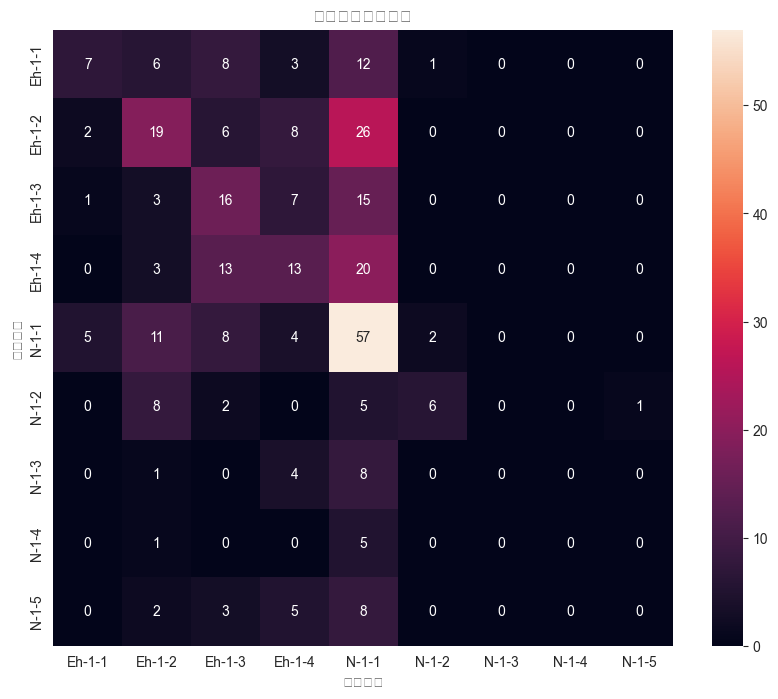

In [9]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Image loading and preprocessing
# -----------------------------
img_data_dir = '../raw'  # Change to your image-dataset folder path

image_features = []  # store 1 024-dimensional image features
img_labels = []      # store class labels

for class_name in os.listdir(img_data_dir):
    class_path = os.path.join(img_data_dir, class_name)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                try:
                    img = Image.open(os.path.join(class_path, filename)).convert('L')
                    img = img.resize((32, 32))
                    img_array = np.array(img).flatten()
                    image_features.append(img_array)
                    img_labels.append(class_name)
                except Exception as e:
                    print(f"Error reading {filename}: {e}")

image_features = np.array(image_features, dtype=np.float32) / 255.0
img_labels = np.array(img_labels)
classes = sorted(np.unique(img_labels))
num_classes = len(classes)

print(f"Image samples: {image_features.shape[0]}, feature dimension: {image_features.shape[1]}")
print(f"Classes: {classes}")

# -----------------------------
# 2. Build Dataset and DataLoader
# -----------------------------
class ImageDataset(Dataset):
    def __init__(self, features, labels, classes):
        self.features = features
        self.labels   = labels
        self.class2idx = {cls: i for i, cls in enumerate(classes)}

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.class2idx[self.labels[idx]], dtype=torch.long)
        return x, y

X_train, X_test, y_train, y_test = train_test_split(
    image_features, img_labels,
    test_size=0.1, random_state=42, stratify=img_labels
)

train_dataset = ImageDataset(X_train, y_train, classes)
test_dataset  = ImageDataset(X_test,  y_test,  classes)
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader   = DataLoader(test_dataset,  batch_size=64, shuffle=False)

print(f"Training samples: {len(train_dataset)}, test samples: {len(test_dataset)}")

# -----------------------------
# 3. Define a simple image-only classifier
# -----------------------------
class ImageClassifier(nn.Module):
    def __init__(self, input_dim=1024, hidden_dim=128, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model  = ImageClassifier(input_dim=1024, hidden_dim=128, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# -----------------------------
# 4. Train the model
# -----------------------------
criterion   = nn.CrossEntropyLoss()
optimizer   = optim.Adam(model.parameters(), lr=1e-4)
num_epochs  = 30

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss   = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss/len(train_dataset):.4f}")

# -----------------------------
# 5. Evaluate the model
# -----------------------------
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        logits  = model(X_batch)
        preds   = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(y_batch.numpy())

acc = accuracy_score(all_targets, all_preds)
print(f"Test accuracy: {acc:.4f}")
print("Classification report:")
print(classification_report(all_targets, all_preds, target_names=classes))

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=classes, yticklabels=classes,
            cmap="Blues")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Image Classification Confusion Matrix")
plt.show()


In [ ]:
GAT

In [ ]:
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors

from torch_geometric.data import Data
from torch_geometric.nn import GATConv

# 1. Data loading and preprocessing
# Replace data_dir with the path to your extracted dataset folder
data_dir = '../raw'

X = []  # store image data
y = []  # store class labels

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                file_path = os.path.join(class_path, filename)
                try:
                    img = Image.open(file_path)
                    img = img.convert('L')          # convert to grayscale
                    img = img.resize((32, 32))      # resize to 32 × 32
                    img_array = np.array(img).flatten()  # flatten to a 1024-dim vector
                    X.append(img_array)
                    y.append(class_name)
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")

X = np.array(X, dtype='float32') / 255.0  # normalize
y = np.array(y)
print("Total images loaded:", X.shape[0])
print("Features per sample:", X.shape[1])
print("Original class labels:", np.unique(y))

# 2. Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)
print("Number of encoded classes:", num_classes)

# 3. Build graph structure (KNN)
k = 10  # number of neighbors
nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(X)
distances, indices = nbrs.kneighbors(X)

edge_index = []
num_nodes = X.shape[0]
for i in range(num_nodes):
    for j in indices[i]:
        if i != j:                       # exclude self-loops (add if needed)
            edge_index.append([i, j])
            edge_index.append([j, i])    # add reverse edge for an undirected graph

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# 4. Build PyG Data object
x_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)
data = Data(x=x_tensor, edge_index=edge_index, y=y_tensor)

# Stratified 80 %/20 % train/test node split
indices = np.arange(num_nodes)
train_idx, test_idx = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=y_encoded
)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask  = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx]   = True
data.train_mask = train_mask
data.test_mask  = test_mask

print("Training nodes:", int(train_mask.sum()))
print("Test nodes    :", int(test_mask.sum()))

# 5. Define the GAT model
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels,
                 out_channels, heads=8, dropout=0.6):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels,
                            heads=heads, dropout=dropout)
        # First layer output dim is hidden_channels * heads
        self.gat2 = GATConv(hidden_channels * heads, out_channels,
                            heads=1, concat=False, dropout=dropout)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(in_channels=X.shape[1],
            hidden_channels=64,
            out_channels=num_classes).to(device)
data = data.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# 6. Train the GAT model
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}")

# 7. Evaluate the model
model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    print(f"Test accuracy: {acc:.4f}")


In [ ]:
GCN

In [ ]:
import os
from PIL import Image
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.optim as optim

# 1. Image loading and preprocessing
# Replace data_dir with the path to your extracted dataset
data_dir = '../raw'

X = []  # store image data
y = []  # store class labels

# Traverse the dataset folder; each sub-folder represents a class
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                file_path = os.path.join(class_path, filename)
                try:
                    img = Image.open(file_path)
                    img = img.convert('L')            # convert to grayscale
                    img = img.resize((32, 32))        # resize to 32 × 32
                    img_array = np.array(img).flatten()  # flatten to 1 024-dim vector
                    X.append(img_array)
                    y.append(class_name)
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")

X = np.array(X, dtype='float32') / 255.0  # normalize
y = np.array(y)
print("Total images loaded:", X.shape[0])
print("Feature dimension per sample:", X.shape[1])
print("Original class labels:", np.unique(y))

# 2. Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)
print("Number of encoded classes:", num_classes)

# 3. Build graph structure with KNN
k = 10  # number of neighbors
nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(X)
_, indices = nbrs.kneighbors(X)

edge_index = []
num_nodes = X.shape[0]
for i in range(num_nodes):
    for j in indices[i]:
        if i != j:                       # exclude self-loops (add if needed)
            edge_index.append([i, j])
            edge_index.append([j, i])    # add reverse edge to make an undirected graph

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# 4. Build PyG Data object
x_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)
data = Data(x=x_tensor, edge_index=edge_index, y=y_tensor)

# Stratified 80 %/20 % train/test node split
indices = np.arange(num_nodes)
train_idx, test_idx = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=y_encoded
)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask  = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx]   = True
data.train_mask = train_mask
data.test_mask  = test_mask

print("Training nodes:", int(train_mask.sum()))
print("Test nodes    :", int(test_mask.sum()))

# 5. Define the GCN model
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=X.shape[1],
            hidden_channels=64,
            out_channels=num_classes).to(device)
data = data.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# 6. Train the GCN model
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out  = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}")

# 7. Evaluate the model
model.eval()
with torch.no_grad():
    out  = model(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    print(f"Test accuracy: {acc:.4f}")


In [ ]:
ResNet

In [ ]:
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

# 1. Image loading and preprocessing
data_dir = '../raw'  # Change to your dataset path; each subfolder corresponds to a class
image_size = (32, 32)  # Image size (H, W)

X = []  # store image data
y = []  # store class labels

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                file_path = os.path.join(class_path, filename)
                try:
                    img = Image.open(file_path)
                    img = img.convert('L')               # convert to grayscale
                    img = img.resize(image_size)         # resize to 32×32
                    img_array = np.array(img, dtype=np.float32) / 255.0  # normalize to [0,1]
                    X.append(img_array)
                    y.append(class_name)
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")

X = np.array(X)  # shape: (N, H, W)
y = np.array(y)
print("Total images loaded:", X.shape[0])
print("Image size:", X.shape[1:], "Original class labels:", np.unique(y))

# 2. Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)
print("Number of encoded classes:", num_classes)

# 3. Build Dataset and DataLoader
class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images  # shape: (N, H, W)
        self.labels = labels
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # convert to [C, H, W]; grayscale so C = 1
        image = self.images[idx]
        image = np.expand_dims(image, axis=0)
        label = self.labels[idx]
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

indices = np.arange(len(X))
train_idx, test_idx = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=y_encoded
)
train_images, test_images = X[train_idx], X[test_idx]
train_labels, test_labels = y_encoded[train_idx], y_encoded[test_idx]

train_dataset = ImageDataset(train_images, train_labels)
test_dataset  = ImageDataset(test_images,  test_labels)

batch_size   = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# 4. Define the ResNet model
# 4.1 BasicBlock
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes, eps=1e-5)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes, eps=1e-5)
        
        self.downsample = None
        if stride != 1 or in_planes != planes:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes, eps=1e-5)
            )
            
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

# 4.2 ResNet backbone
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, in_channels=1):
        super().__init__()
        self.in_planes = 64
        # For small images, use 3×3 conv with stride 1
        self.conv1 = nn.Conv2d(
            in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1  = nn.BatchNorm2d(64, eps=1e-5)
        self.relu = nn.ReLU(inplace=True)
        
        # layer1: no downsampling; layer2–4: downsample
        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride):
        layers = [block(self.in_planes, planes, stride)]
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        
        x = self.layer1(x); x = self.layer2(x)
        x = self.layer3(x); x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet18(num_classes, in_channels=1):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, in_channels=in_channels)

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = resnet18(num_classes=num_classes, in_channels=1).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 5. Training and evaluation
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Evaluate on the test set
model.eval()
correct = 0
total   = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs        = model(images)
        _, predicted   = torch.max(outputs, 1)
        total  += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test accuracy: {accuracy:.4f}")


heterognn+resnet

In [ ]:
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# -----------------------------
# 1. Image loading and preprocessing
# -----------------------------
data_dir   = '../raw'          # Path to your image-dataset folder; each sub-folder is a class
image_size = (32, 32)          # Image size (H, W)

images = []  # store image data (H, W)
labels = []  # store class labels

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                file_path = os.path.join(class_path, filename)
                try:
                    img = Image.open(file_path)
                    img = img.convert('L')                 # grayscale
                    img = img.resize(image_size)
                    img_array = np.array(img, dtype=np.float32) / 255.0  # normalize to [0, 1]
                    images.append(img_array)
                    labels.append(class_name)
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")

images = np.array(images)      # (N, H, W)
labels = np.array(labels)
print("Total images loaded:", images.shape[0])
print("Image size:", images.shape[1:], "Original class labels:", np.unique(labels))

# Label encoding
le         = LabelEncoder()
y_encoded  = le.fit_transform(labels)
num_classes = len(le.classes_)
print("Number of encoded classes:", num_classes)

# Dataset definition
class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images   # (N, H, W)
        self.labels = labels
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # convert to [C, H, W]; grayscale so C = 1
        img   = np.expand_dims(self.images[idx], axis=0)
        label = self.labels[idx]
        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Train / test split
indices = np.arange(len(images))
train_idx, test_idx = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=y_encoded
)
train_images, test_images   = images[train_idx], images[test_idx]
train_labels, test_labels   = y_encoded[train_idx], y_encoded[test_idx]

train_dataset = ImageDataset(train_images, train_labels)
test_dataset  = ImageDataset(test_images,  test_labels)

batch_size   = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# -----------------------------
# 2. Graph-data encoding (HeteroGNN)
# -----------------------------
# Example: suppose your heterogeneous-graph data are stored in a dict;
# each node type has its own feature matrix.  Adjust to match your data.
graph_data = {
    'type1': torch.randn(10, 16),   # 10 nodes, 16-dim features
    'type2': torch.randn(15, 16)    # 15 nodes, 16-dim features
}

class HeteroGNNEncoder(nn.Module):
    """
    Simple heterogeneous-graph encoder.

    Args
    ----
    in_feats : input feature dimension (assumed identical across types)
    hidden_feats : hidden dimension
    out_feats : dimension of the final graph embedding
    """
    def __init__(self, in_feats, hidden_feats, out_feats):
        super().__init__()
        # For simplicity every node uses the same two-layer MLP
        self.fc1 = nn.Linear(in_feats,  hidden_feats)
        self.fc2 = nn.Linear(hidden_feats, out_feats)
        
    def forward(self, graph_dict):
        encodings = []
        for _, feats in graph_dict.items():          # feats: (N_i, in_feats)
            h = F.relu(self.fc1(feats))
            h = self.fc2(h)                          # (N_i, out_feats)
            encodings.append(h)
        all_feats = torch.cat(encodings, dim=0)      # (Σ nodes, out_feats)
        return all_feats.mean(dim=0)                 # (out_feats,)

heterognn_encoder = HeteroGNNEncoder(in_feats=16, hidden_feats=32, out_feats=768)
heterognn_encoder.eval()
with torch.no_grad():
    graph_hidden_state = heterognn_encoder(graph_data)  # (768,)
print("Graph-embedding vector shape:", graph_hidden_state.shape)

# -----------------------------
# 3. ResNet with graph-plugin fusion
# -----------------------------
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)
        self.down  = None
        if stride != 1 or in_planes != planes:
            self.down = nn.Sequential(
                nn.Conv2d(in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.down is not None:
            identity = self.down(x)
        out = self.relu(out + identity)
        return out

class ResNetPlugin(nn.Module):
    def __init__(self, block, layers, num_classes, in_channels=1, graph_dim=768):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(in_channels, 64, 3, 1, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        
        self.layer1 = self._make_layer(block, 64,  layers[0], 1)
        self.layer2 = self._make_layer(block, 128, layers[1], 2)
        self.layer3 = self._make_layer(block, 256, layers[2], 2)
        self.layer4 = self._make_layer(block, 512, layers[3], 2)
        
        self.avgpool   = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_plugin = nn.Linear(512 + graph_dim, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride):
        layers = [block(self.in_planes, planes, stride)]
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x, graph_vector):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x); x = self.layer2(x)
        x = self.layer3(x); x = self.layer4(x)
        
        x = self.avgpool(x).flatten(1)            # (B, 512)
        B = x.size(0)
        graph_expanded = graph_vector.unsqueeze(0).expand(B, -1)  # (B, graph_dim)
        fused = torch.cat([x, graph_expanded], dim=1)
        return self.fc_plugin(fused)

def resnet18_plugin(num_classes, in_channels=1, graph_dim=768):
    return ResNetPlugin(BasicBlock, [2, 2, 2, 2],
                        num_classes=num_classes,
                        in_channels=in_channels,
                        graph_dim=graph_dim)

# -----------------------------
# 4. Training and evaluation
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = resnet18_plugin(num_classes=num_classes, in_channels=1, graph_dim=768).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

graph_hidden_state = graph_hidden_state.to(device)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs, graph_hidden_state)
        loss    = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch + 1}/{num_epochs} — Loss: {epoch_loss:.4f}")

# Evaluation and confusion matrix
model.eval()
y_true, y_pred = [], []
correct, total = 0, 0

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outputs    = model(imgs, graph_hidden_state)
        _, preds   = torch.max(outputs, 1)
        total  += lbls.size(0)
        correct += (preds == lbls).sum().item()
        y_true.extend(lbls.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

accuracy = correct / total
print(f"Test accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
ticks = np.arange(num_classes)
plt.xticks(ticks, le.classes_, rotation=45)
plt.yticks(ticks, le.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()
